# Smile Detection Model Training based on CNN  
In this notebook, images that were scrapped from the script `getty_scraper.py` will be pre-processed and used in a Convolutional Neural Network (CNN) to train a model to detect if a person is smiling or not.

This notebook can also be used as a guide for any future image processing and neural network training.

Note: Some parts of this notebook may require more computer power and time, so it might be a good idea to spin up a server to help process it.

## Library Imports

In [1]:
# !pip install face_recognition
# !pip install dlib

In [47]:
import os
from PIL import Image
import face_recognition
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

## (example) Using the Image class from PIL
Images scraped for 'smile' and 'no smile' are located in the `./images/` directory. Landscape images are roughly all of size 612 x 408 and portraits 408 x 612.

In [3]:
# load image with Pillow
img = Image.open('./images/smile/0.jpg')

In [4]:
# summarize some details about the image
from __future__ import print_function
print(img.format, img.size, img.mode)

JPEG (612, 408) RGB


In [5]:
# show the image
img.show()

In [6]:
# 6080 smile images scrapped
list = os.listdir('./images/smile/')
number_files = len(list)
print(number_files)

6080


In [7]:
# 6040 no_smile images scrapped
list = os.listdir('./images/no_smile/')
number_files = len(list)
print(number_files)

6040


---

# Image Pre-processing Steps:
Computers can't just take images and do math on them! We'll need to do some pre-processing before we can train a model. 

Here are the steps that were taken:
1. Using `face_recognition` package to detect location of face in an image
2. Convert to grayscale
3. Crop image around the face bounding box
4. Resize to 100 x 100 px
5. Convert into an array
6. Transformations (normalization and label encoding)
7. Train, test, split

## Crop Face and Resize
The simplest `face_recognition` library was used to recognize and manipulate faces from Python, built using dlib’s state-of-the-art face recognition with deep learning. The library's documentation can be found [here](https://face-recognition.readthedocs.io/en/latest/index.html).

With location of faces detected within each image, the images were cropped with a bounding box around the face and resized down to 100x100 pixels. Smaller and grayscale images are easier and faster to work with (to start!) for CNNs.

The processed images were saved in the `./images/` directory under `{term}_gray_crop_face` folders

In [8]:
img_width, img_height = (100, 100)
search_terms = ['no_smile', 'smile']

In [9]:
# iterate through smile and no_smile folder
# uncomment to execute again

# for term in search_terms:
    
#     # folder with original images
#     orig_path = f'./images/{term}'
    
#     # folder for processed images
#     new_path = f'./images/{term}_gray_crop_face'
#     os.makedirs(new_path)
    
#     # iterate through all images
#     for img_filename in os.listdir(orig_path):  
       
#         if img_filename.endswith('.jpg'): # exclude all other file types
#             img = Image.open(f'{orig_path}/{img_filename}')
            
#             # convert to grayscale
#             img_grayscale = img.convert("L")
            
#             # load image into a numpy array
#             image = face_recognition.load_image_file(f'{orig_path}/{img_filename}')
            
#             # detect face and return top, right, bottom, left face bounding box pixel location
#             face_locations = face_recognition.face_locations(image) # can set model = 'cnn' (more accurate but way slower)
            
#             # only include images with one face identified
#             # if multiple faces are identified, the secondary ones might not be linked to the smile or no_smile category labeled by Getty Images
#             if len(face_locations) == 1:
#                 top, right, bottom, left = face_locations[0]
#                 box = (left, top, right, bottom)
                
#                 # crop face and resize to 100x10
#                 img_resized = img_grayscale.resize((img_width, img_height), box = box)
                
#                 # save new images
#                 img_resized.save(f'{new_path}/{img_filename}')

In [10]:
# 5201 smile images remaining in dataset
list = os.listdir('./images/smile_gray_crop_face')
number_files = len(list)
print(number_files)

5201


In [11]:
# 4495 no_smile images remaining in dataset
list = os.listdir('./images/no_smile_gray_crop_face')
number_files = len(list)
print(number_files)

4495


## Convert Images to NumPy Arrays
We converted 4400 images each, from the processed smile and no_smile images, to be included in our dataset.

In [12]:
X = [] # list of arrays with shape (300,300,1) for each image
y = [] # smile or no_smile associated with corresponding image

# iterate through smile_gray_crop_face and no_smile_gray_crop_face folder
for term in search_terms:
    path = f'./images/{term}_gray_crop_face'
    image_nos = os.listdir(path)
    for image_no in range(0, 4400):
        img = Image.open(f'{path}/{image_nos[image_no]}')
        img_array = img_to_array(img)
        X.append(img_array)
        y.append(term)

In [13]:
# convert to np.array
X = np.array(X)
y = np.array(y)

In [14]:
X.shape

(8800, 100, 100, 1)

In [15]:
y.shape

(8800,)

In [16]:
# examples
X[0].shape

(100, 100, 1)

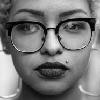

In [17]:
array_to_img(X[0])

In [18]:
y[0]

'no_smile'

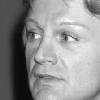

In [19]:
array_to_img(X[100])

In [20]:
y[100]

'no_smile'

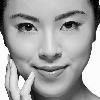

In [21]:
array_to_img(X[8599])

In [22]:
y[8599]

'smile'

## Train Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 73, stratify = y)

## Transformation (MinMaxScaler and LabelEncoder)

In [24]:
# use MinMaxScaler for normalization of X data
# reshaped to be able to use MinMaxScaler()
X_train = X_train.reshape(X_train.shape[0], img_width*img_height)
X_test = X_test.reshape(X_test.shape[0], img_width*img_height)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
X_train.shape

(7040, 10000)

In [26]:
X_test.shape

(1760, 10000)

In [27]:
# save scaler
scaler_filename = "./models/scaler.save"
joblib.dump(scaler, scaler_filename) 

['./models/scaler.save']

In [28]:
# use LabelEncoder for encoding of y categories
# this will be done alphabetically
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

y_train = to_categorical(encoded_y_train)
y_test = to_categorical(encoded_y_test)

In [29]:
y_train.shape

(7040, 2)

In [30]:
y_test.shape

(1760, 2)

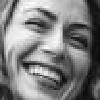

In [31]:
# examples
array_to_img(X_train.reshape(X_train.shape[0], img_width, img_height, 1)[3])

In [32]:
# labels for [no_smile, smile]
y_train[2]

array([0., 1.], dtype=float32)

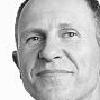

In [33]:
array_to_img(X_train.reshape(X_train.shape[0], img_width, img_height, 1)[2000])

In [34]:
y_train[2000] # [no_smile, smile]

array([1., 0.], dtype=float32)

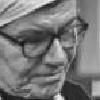

In [35]:
array_to_img(X_train.reshape(X_train.shape[0], img_width, img_height, 1)[6878])

In [36]:
y_train[6878] # [no_smile, smile]

array([1., 0.], dtype=float32)

---

# Modeling Steps:
Now we are ready to train our model. 

Here are the steps that were taken:
1. Use `ImageDataGenerator` to configure random transformations and normalization operations on our dataset during training
2. Create our CNN model
3. Train the model
4. Save model

## ImageDataGenerator

In [37]:
# configure random transformations and normalization operations 
# to be done on your image data during training
datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [38]:
# reshape back to shape to use in model
X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 1)
X_test = X_test.reshape(X_test.shape[0], img_width, img_height, 1)

In [39]:
X_train.shape

(7040, 100, 100, 1)

In [40]:
X_test.shape

(1760, 100, 100, 1)

## Convolutional Neural Network

In [41]:
# shape is the bane of my existence!
# FYI, this is what we are working with
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7040, 100, 100, 1)
(1760, 100, 100, 1)
(7040, 2)
(1760, 2)


In [42]:
# create CNN model with the following 2 conv layers and 1 dense layer
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [43]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
tf.keras.backend.clear_session()

In [45]:
epochs = 100 # for training, for testing use 25

early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta=0, patience=10, mode='auto', restore_best_weights = True)

history = model.fit_generator(datagen.flow(X_train, y_train),
          epochs = epochs,
          callbacks = [early_stop],
          verbose = 1,
          validation_data = (X_test, y_test))

Epoch 1/100
220/220 [==============================] - 94s 427ms/step - loss: 0.7163 - accuracy: 0.5747 - val_loss: 0.5937 - val_accuracy: 0.7256
Epoch 2/100
220/220 [==============================] - 94s 427ms/step - loss: 0.6123 - accuracy: 0.6741 - val_loss: 0.5326 - val_accuracy: 0.7324
Epoch 3/100
220/220 [==============================] - 92s 417ms/step - loss: 0.5677 - accuracy: 0.7016 - val_loss: 0.4503 - val_accuracy: 0.7926
Epoch 4/100
220/220 [==============================] - 92s 420ms/step - loss: 0.5323 - accuracy: 0.7294 - val_loss: 0.3984 - val_accuracy: 0.8131
Epoch 5/100
220/220 [==============================] - 92s 420ms/step - loss: 0.4985 - accuracy: 0.7521 - val_loss: 0.3742 - val_accuracy: 0.8341
Epoch 6/100
220/220 [==============================] - 94s 426ms/step - loss: 0.4699 - accuracy: 0.7686 - val_loss: 0.3737 - val_accuracy: 0.8403
Epoch 7/100
220/220 [==============================] - 85s 385ms/step - loss: 0.4578 - accuracy: 0.7844 - val_loss: 0.3978 -

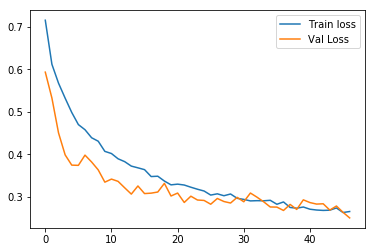

In [48]:
# plot loss history through epochs
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend();

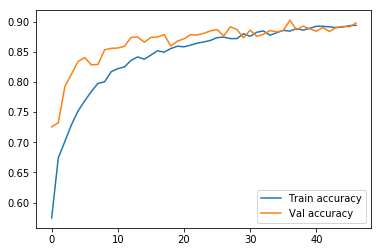

In [49]:
# plot accuracy history through epochs
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend();

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0

In [51]:
# save the model in a HDF5 file 'my_model.h5'
model.save('./models/my_model.h5')

This CNN model can predict smiles with an accuracy of approx . This is already pretty good. 

We can later come back to improve the model.

Some ideas for improvements include:
- Relabel dataset to ensure images are correctly categorized as smile or no smile
- Optimizing neural network parameters
- Increasing dataset
- Using larger image sizes
- Using RGB images instead of grayscale

# Finally, testing it out!
Now that we have our model, I created a Flask app to import some new images (taken from a webcam) and predict if the person in the image is smiling or not. Also for a sanity check to see how well the model can be used with new images!

The app can be generated with the following files:

- `app.py`: main application to run
- `camera.py`: contains Camera object to capture live video feed and `get_frame()` function return image with a bounding box marked around the face and text indicating smile probabilities
- `smile_recognition.py`: contains `predict_smile()` function which takes in an image frame and returns smile predictions